In [162]:
import numpy as np
import numpy.linalg as LA
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

def newman_watts_esn_W(N, k=3, p=0.05, rho_target=0.99, seed=None):
    """
    Newman–Watts small-world をベースにした ESN 用の有向重み行列 W を作成。
    - N: ノード数
    - k: 片側の局所近傍（各ノードは左右 k 本ずつ、計 2k 本の規則エッジを持つ）
    - p: ランダム近道（shortcuts）を「追加」する確率（0.01〜0.1 くらいが目安）
    - rho_target: 最後にスペクトル半径をこの値にスケール
    """
    if seed is None:
        rng = np.random.default_rng()
    elif seed is not None:
        rng = np.random.default_rng(seed)

    # 1) 規則格子（リング）上の有向隣接行列
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        for d in range(1, k+1):
            A[i, (i + d) % N] = 1.0
            A[i, (i - d) % N] = 1.0

    # 2) Newman–Watts: 既存の格子を残したまま、確率 p でランダムな“近道”を追加
    #    自己ループは避ける
    mask = rng.random((N, N)) < p
    np.fill_diagonal(mask, False)
    A = np.where(mask, 1.0, A)

    # 3) エッジにランダム重み付け（符号付き一様）
    W = np.zeros_like(A)
    # 一様[-1,1] の重みを、エッジがあるところだけに割り当て
    W[A > 0] = rng.uniform(-1.0, 1.0, size=(A > 0).sum())

    # 4) スペクトル半径を rho_target にスケーリング
    eigvals = np.linalg.eigvals(W)
    rho = np.max(np.abs(eigvals)) if eigvals.size else 1.0
    if rho > 0:
        W = (rho_target / rho) * W
    return W, A

def visualize_ring_network(A, title="Small-world Reservoir"):
    """
    隣接行列 A（0/1 行列）を環状レイアウトで可視化する
    """
    N = A.shape[0]
    # 有向グラフとして読み込み
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)
    
    # 環状レイアウト（ノードを円周上に等間隔配置）
    pos = nx.circular_layout(G)

    # 図を描画
    plt.figure(figsize=(10, 10), dpi=120)
    nx.draw_networkx_nodes(G, pos, node_size=80, node_color="skyblue")
    nx.draw_networkx_edges(G, pos, arrows=False, width=0.6, alpha=0.5)
    plt.title(title, size=20)
    plt.axis("off")
    plt.show()

In [139]:
class EchoStateNetwork:
    def __init__(self,
                N=300,             # リザーバノード数
                rho=0.99,          # スペクトル半径ターゲット
                alpha=0.3,         # リーク率（0<alpha<=1）,
                scaling_input = 1.0, # 入力のスケーリング
                dim_input = 1
                ):
        self.N = N
        self.rho = rho
        self.alpha = alpha
                    
        # ノード状態の更新行列
        self.W_res = np.random.uniform(-1.0, 1.0, (N, N))
        mask = np.random.binomial(1, 0.2, (N, N))
        self.W_res = np.multiply(self.W_res, mask)
        self.W_in =　np.random.uniform(-scaling_input, scaling_input, (N, dim_input))
        self.W_out = None
        return 0
    def train(self, u_in, target):
        self.reservior_states = self.run_reservior(u_in)
        self.W_out = np.linalg.pinv(self.reservior_states) @ target
        
sw_esm = 

In [213]:
import numpy as np
import random
from collections import deque

# --- 基本構築部 ---
def ring_lattice_adj(N, k):
    """Nノード, 各ノードがk/2ずつ両隣に接続した格子ネットワークの隣接行列"""
    assert k % 2 == 0 and k < N, "kは偶数かつNより小さい必要があります"
    A = np.zeros((N, N), dtype=bool)
    half = k // 2
    for i in range(N):
        for d in range(1, half + 1):
            j1 = (i + d) % N
            j2 = (i - d) % N
            A[i, j1] = A[j1, i] = True
            A[i, j2] = A[j2, i] = True
    return A

def watts_strogatz_rewire(A, p, rng=random):
    """Watts-Strogatz 再配線処理: 各ノードの右側エッジを確率pでランダムに付け替え"""
    N = A.shape[0]
    half = np.sum(A[0]) // 2
    A = A.copy()
    for i in range(N):
        rights = [(i + d) % N for d in range(1, half + 1)]
        for j in rights:
            if not A[i, j]:
                continue
            if rng.random() < p:
                A[i, j] = A[j, i] = False
                candidates = list(set(range(N)) - set(np.where(A[i])[0]) - {i})
                if candidates:
                    m = rng.choice(candidates)
                    A[i, m] = A[m, i] = True
    return A

# --- 指標計算部 ---
def clustering_coefficient(A):
    """平均クラスタ係数 C を計算"""
    N = A.shape[0]
    C_vals = []
    for i in range(N):
        neighbors = np.where(A[i])[0]
        k_i = len(neighbors)
        if k_i < 2:
            C_vals.append(0.0)
            continue
        subA = A[np.ix_(neighbors, neighbors)]
        e_i = np.sum(subA) / 2
        C_i = (2 * e_i) / (k_i * (k_i - 1))
        C_vals.append(C_i)
    return np.mean(C_vals)

def average_path_length(A):
    """平均最短経路長 L を計算"""
    N = A.shape[0]
    total = 0
    count = 0
    for s in range(N):
        dist = [-1]*N
        dist[s] = 0
        q = deque([s])
        while q:
            v = q.popleft()
            for w in np.where(A[v])[0]:
                if dist[w] == -1:
                    dist[w] = dist[v] + 1
                    q.append(w)
        for t in range(s+1, N):
            if dist[t] != -1:
                total += dist[t]
                count += 1
    return total / count if count > 0 else float('inf')

# --- メイン関数 ---
def watts_strogatz(N=200, k=6, p=0.05, seed=42):
    """
    Watts-Strogatz スモールワールドネットワークを生成し、CとLを返す
    N: ノード数
    k: 各ノードの近傍接続数（偶数）
    p: 再配線確率
    seed: 乱数シード
    Returns:
        A: 隣接行列 (N×N, bool)
        C: クラスタ係数
        L: 平均経路長
    """
    rng = random.Random(seed)
    A0 = ring_lattice_adj(N, k)
    A = watts_strogatz_rewire(A0, p, rng)
    C = clustering_coefficient(A)
    L = average_path_length(A)
    return A, C, L
N = 10
k = 2
p = 0.
_A,_C,_L = watts_strogatz(N, k, p, seed=2)

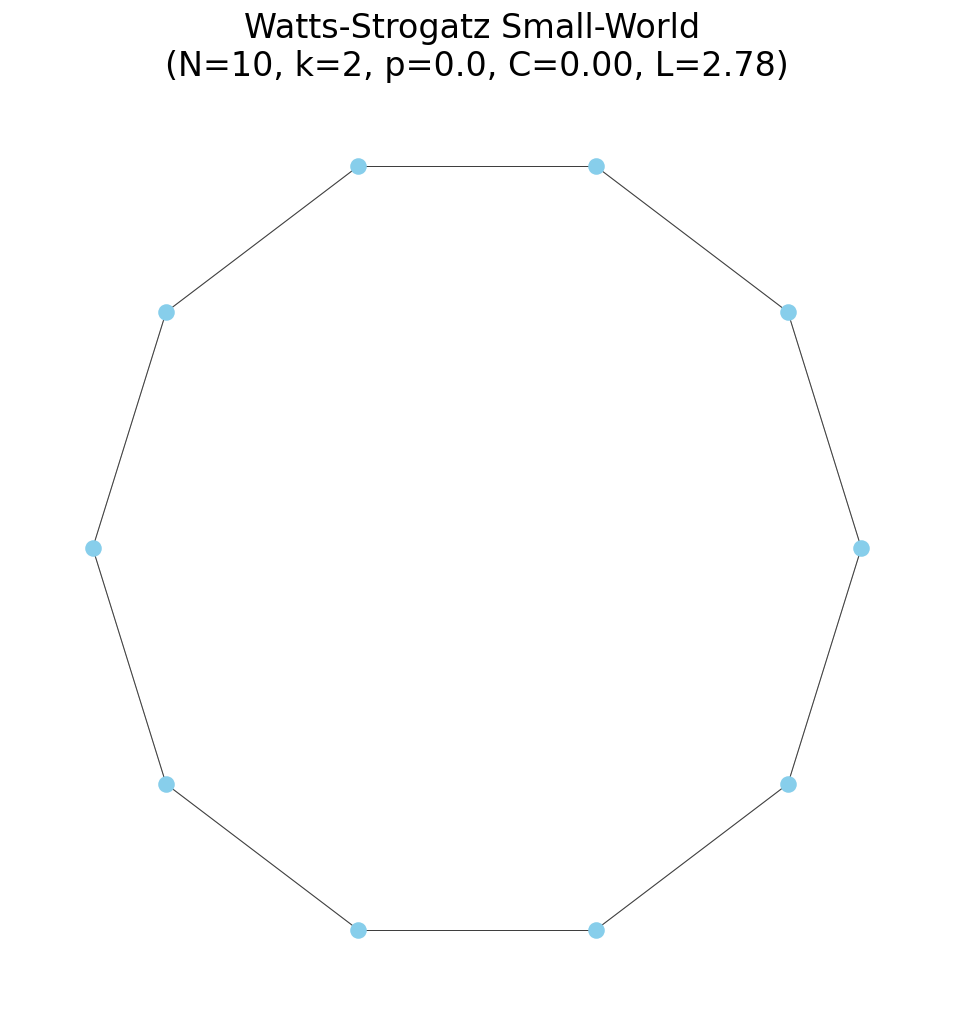

In [214]:
# Wr, A = newman_watts_esn_W(N=N, k=k, p=p, seed=0)
# d, V = np.linalg.eig(Wr)
# print("spectral radius", np.real(d[0]))
visualize_ring_network(_A, title="Watts-Strogatz Small-World \n(N={}, k={}, p={}, C={:.2f}, L={:.2f})".format(N, k, p, _C, _L))

In [106]:
def mackey_glass(T=12000, tau=17, beta=0.2, gamma=0.1, n=10, dt=1.0, x0=1.2):
    """
    オイラー法 + 遅延バッファで離散化。T ステップ分の系列を返す。
    """
    delay = int(round(tau/dt))
    x = np.zeros(T + delay + 1)
    x[:delay+1] = x0
    for t in range(delay, T + delay):
        x_tau = x[t - delay]
        x[t+1] = x[t] + dt*(beta * x_tau / (1 + x_tau**n) - gamma * x[t])
    return x[delay+1:]  # 遅延ぶんを落として長さTに揃える
# ---------------------------
# 3) ESN（リーキー型、出力は線形）
# ---------------------------
def run_esn_smallworld_mg(
    N=300,            # リザーバノード数
    k=3, p=0.05,      # small-world ハイパラ
    rho=0.99,         # スペクトル半径ターゲット
    alpha=0.3,        # リーク率（0<alpha<=1）
    in_scale=0.4,     # 入力スケール
    ridge=1e-3,       # Ridge 係数
    washout=1000,     # ウォッシュアウト
    train_len=5000,   # 学習長
    test_len=2000,    # テスト長
    seed=0
):
    rng = np.random.default_rng(seed)

    # データ生成（標準化して使う）
    T_total = washout + train_len + test_len + 10
    mg = mackey_glass(T=T_total, tau=17)
    mg = (mg - mg.mean()) / (mg.std() + 1e-8)
    u = mg.reshape(-1, 1)  # 入力として同系列を使い、次ステップを予測する one-step-ahead

    # リザーバ生成
    Wr, _ = newman_watts_esn_W(N, k=k, p=p, rho_target=rho, seed=seed)
    Win = rng.uniform(-in_scale, in_scale, size=(N, 1))  # 1次元入力
    # 出力は x からの線形（バイアス付けると安定）： [x; 1] に回帰
    # 初期状態
    x = rng.uniform(-1.0, 1.0, size=(N,))

    # 走査して状態を貯める
    X_collect = []
    Y_collect = []
    for t in range(T_total-1):
        # リーキーESN更新
        pre = Wr @ x + Win.flatten() * u[t, 0]
        x = (1 - alpha) * x + alpha * np.tanh(pre)
        # 学習データ収集（washout後）
        if t >= washout and t < washout + train_len:
            X_collect.append(np.hstack([x, 1.0]))                  # バイアス列を足す
            Y_collect.append(u[t+1, 0])                            # 1ステップ先を教師に
    X_collect = np.asarray(X_collect)   # [train_len, N+1]
    Y_collect = np.asarray(Y_collect)   # [train_len]

    # Ridge 回帰で Wout 学習： (X^T X + βI)^{-1} X^T y
    XT = X_collect.T
    G = XT @ X_collect + ridge * np.eye(N+1)
    Wout = (LA.solve(G, XT @ Y_collect)).reshape(-1, 1)  # [N+1, 1]

    # テスト
    preds = []
    targets = []
    # t を学習終了点から最後まで回す
    x = x.copy()  # 直前の状態から続行
    for t in range(washout + train_len, T_total-1):
        pre = Wr @ x + Win.flatten() * u[t, 0]
        x = (1 - alpha) * x + alpha * np.tanh(pre)
        y_hat = np.hstack([x, 1.0]) @ Wout    # 予測
        preds.append(float(y_hat))
        targets.append(float(u[t+1, 0]))

    preds = np.asarray(preds)
    targets = np.asarray(targets)

    # ---- 複数ステップ（free-run / 自己回帰） ----
    preds_multi = []
    targets_multi = []
    x_m = x.copy()  # 同じ起点から
    # 最初の一歩だけは真の入力を種にする（境界条件）
    u_in = float(u[washout + train_len, 0])
    
    for t in range(washout + train_len, T_total - 1):
        pre = Wr @ x_m + Win.flatten() * u_in
        x_m = (1 - alpha) * x_m + alpha * np.tanh(pre)
        y_hat = float(np.hstack([x_m, 1.0]) @ Wout)
        preds_multi.append(y_hat)
        targets_multi.append(float(u[t+1, 0]))
        # ここが one-step と違う：予測を次の入力にフィードバック
        u_in = y_hat
    
    preds_multi   = np.asarray(preds_multi)
    targets_multi = np.asarray(targets_multi)
    
    # NRMSE
    nrmse = np.sqrt(np.mean((preds - targets)**2)) / (np.std(targets) + 1e-8)
    nrmse_multi = np.sqrt(np.mean((preds_multi - targets_multi)**2)) / (np.std(targets_multi) + 1e-8)
    return {
        "Wr": Wr, "Win": Win, "Wout": Wout,
        "preds": preds, "preds_multi": preds_multi,"targets": targets,
        "NRMSE": nrmse,
        "NRMSE_MULTI": nrmse_multi,
        "params": dict(N=N, k=k, p=p, rho=rho, alpha=alpha, in_scale=in_scale, ridge=ridge,
                       washout=washout, train_len=train_len, test_len=test_len)
    }

# ---------------------------
# 実行して可視化
# ---------------------------
res = run_esn_smallworld_mg(
    N=10, k=3, p=0.1, rho=0.99, alpha=0.3,
    in_scale=0.4, ridge=1e-3, washout=1000, train_len=5000, test_len=2000, seed=2
)

/var/folders/cs/f0kzlkp96y3_w0tw04n190tr0000gn/T/ipykernel_24697/2011504419.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  preds.append(float(y_hat))
/var/folders/cs/f0kzlkp96y3_w0tw04n190tr0000gn/T/ipykernel_24697/2011504419.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat = float(np.hstack([x_m, 1.0]) @ Wout)


Mackey–Glass one-step prediction (NRMSE=0.105)
Mackey–Glass multi-step prediction (NRMSE=1.158)


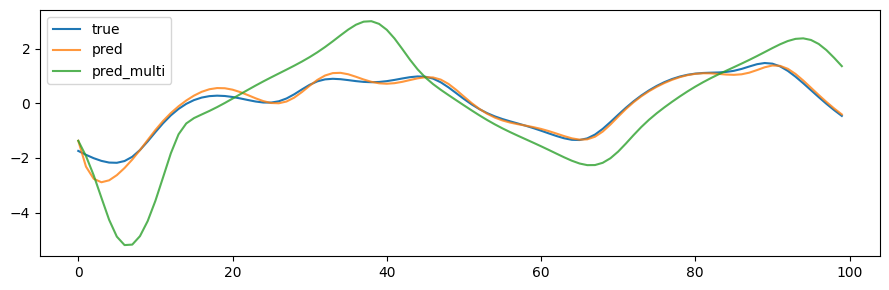

In [107]:
t = 100
plt.figure(figsize=(9,3))
plt.plot(res["targets"][:t], label="true")
plt.plot(res["preds"][:t], label="pred", alpha=0.8)
plt.plot(res["preds_multi"][:t], label="pred_multi", alpha=0.8)
print(f"Mackey–Glass one-step prediction (NRMSE={res['NRMSE']:.3f})")
print(f"Mackey–Glass multi-step prediction (NRMSE={res['NRMSE_MULTI']:.3f})")
plt.legend(); plt.tight_layout(); plt.show()

In [114]:
# ---- 収集用バッファ ----
Xs, Xsp, Us = [], [], []   # x_t, x_{t+1}, u_t
alpha=0.3
in_scale=0.4
ridge=1e-3
washout=1000 
train_len=5000
test_len=2000
Wr = res["Wr"]
Win = res["Win"]
N = Wr.shape[0]
rng = np.random.default_rng()
x = rng.uniform(-1.0, 1.0, size=(N,))

T_total = washout + train_len + test_len + 10
mg = mackey_glass(T=T_total, tau=17)
mg = (mg - mg.mean()) / (mg.std() + 1e-8)
u = mg.reshape(-1, 1) 
# ウォッシュアウト
for t in range(washout):
    pre = Wr @ x + Win[:,0] * u[t,0]
    x = (1 - alpha) * x + alpha * np.tanh(pre)

# 学習区間で保存
for t in range(washout, washout + train_len - 1):
    pre = Wr @ x + Win[:,0] * u[t,0]
    x_next = (1 - alpha) * x + alpha * np.tanh(pre)
    # 保存
    Xs.append(x.copy())           # x_t
    Xsp.append(x_next.copy())     # x_{t+1}
    Us.append([u[t,0]])           # u_t（列ベクトルにしたいので [] で包む）
    # 次へ
    x = x_next

Xs  = np.asarray(Xs)      # shape: [T-1, N]
Xsp = np.asarray(Xsp)     # shape: [T-1, N]
Us  = np.asarray(Us)      # shape: [T-1, 1]
print(Xs.shape)

(4999, 10)


In [115]:
def make_monomial_powers(dim: int, max_order: int) -> np.ndarray:
    """
    総次数 <= max_order の全モノミアルの指数ベクトルを返す。
    例) dim=2, max_order=2 -> [[0,0],[1,0],[0,1],[2,0],[1,1],[0,2]]
    昇順（総次数→辞書順）で並ぶ。
    """
    exps = []
    for total_deg in range(max_order + 1):
        # 仕切り法: d次元の非負整数解の列挙
        # combinations_with_replacementでインデックスの多重集合を生成
        for combo in combinations_with_replacement(range(dim), total_deg):
            e = np.zeros(dim, dtype=np.int16)
            for idx in combo:
                e[idx] += 1
            exps.append(e)
    return np.asarray(exps, dtype=np.int16)
    
class MonomialDictionary:
    """
    ψ(x) = { x^e : e ∈ E }  （E は make_monomial_powers で作った指数集合）
    - 入力 x: shape [d] あるいは [T, d]
    - 出力:   shape [M] あるいは [T, M]  （M=モノミアル数）
    """
    def __init__(self, max_order: int):
        self.max_order = int(max_order)
        self._exps = None  # 遅延構築

    def _ensure_exps(self, d: int):
        if (self._exps is None) or (self._exps.shape[1] != d):
            self._exps = make_monomial_powers(d, self.max_order)

    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = np.asarray(x, dtype=np.float64)
        if x.ndim == 1:
            x = x[None, :]  # [1, d] に拡張
        T, d = x.shape
        self._ensure_exps(d)
        # x^(exps) を効率よく計算： (T,d) と (M,d) から (T,M,d) のべき → 積
        # 1) x を (T,1,d) に、exps を (1,M,d) にブロードキャスト
        xb = x[:, None, :]                  # [T,1,d]
        eb = self._exps[None, :, :]         # [1,M,d]
        # 2) 要素ごとの冪
        with np.errstate(over='ignore', invalid='ignore'):
            powed = np.power(xb, eb, dtype=np.float64)  # [T,M,d]
        # 3) 軸 d で積をとってモノミアル値（x_1^e1 * ... * x_d^ed）
        psi = np.prod(powed, axis=2)        # [T,M]
        return psi if T > 1 else psi[0]     # 入力と同じ次元性に戻す


def fit_edmdc(Xs, Us, Xsp, ridge=1e-6):
    """
    Xs : [T-1, d_x]   （ψ(x_t) を想定）
    Us : [T-1, d_u]   （φ(u_t) を想定）
    Xsp: [T-1, d_x]   （ψ(x_{t+1})）
    で  X' ≈ A X + B U を最小二乗（リッジ）で解く
    """
    # 行列を “列がサンプル” になるように並べる（解析ではこっちが楽）
    X  = Xs.T        # [d_x, T-1]
    Xp = Xsp.T       # [d_x, T-1]
    U  = Us.T        # [d_u, T-1]

    Z  = np.vstack([X, U])               # [d_x + d_u, T-1]
    d_x = X.shape[0]
    d_u = U.shape[0]

    # W = [A  B] をまとめて推定：  Xp ≈ W @ Z
    G = Z @ Z.T + ridge * np.eye(d_x + d_u)
    W = Xp @ Z.T @ np.linalg.inv(G)      # [d_x, d_x + d_u]

    A = W[:, :d_x]
    B = W[:, d_x:]
    return A, B

In [124]:
psi_x = MonomialDictionary(max_order=4)   # 状態の辞書（2次まで）
phi_u = MonomialDictionary(max_order=1)   # 入力の辞書（線形のみ）

# 収集済みの配列:
# Xs: [T-1, N],  Xsp: [T-1, N],  Us: [T-1, m]

PhiX  = psi_x(Xs)     # [T-1, Mx]
print(PhiX.shape)
PhiXp = psi_x(Xsp)    # [T-1, Mx]
PhiU  = phi_u(Us)     # [T-1, Mu]

# 行列を“列=サンプル”にして EDMDc
X   = PhiX.T          # [Mx, T-1]
Xp  = PhiXp.T         # [Mx, T-1]
U   = PhiU.T          # [Mu, T-1]
Z   = np.vstack([X, U])     # [Mx+Mu, T-1]
ridge = 1e-4
G = Z @ Z.T + ridge * np.eye(Z.shape[0])
W = Xp @ Z.T @ np.linalg.inv(G)           # [Mx, Mx+Mu]
A_edmd = W[:, :X.shape[0]]
B_edmd = W[:, X.shape[0]:]

(4999, 1001)


/var/folders/cs/f0kzlkp96y3_w0tw04n190tr0000gn/T/ipykernel_24697/564167257.py:18: RuntimeWarning: invalid value encountered in matmul
  G = Z @ Z.T + ridge * np.eye(Z.shape[0])


In [125]:
# 固有分解（数値安定が気になれば Schur 分解でもOK）
lam, V = np.linalg.eig(A_edmd)    # A V = V Λ

# “入力でどれだけ励起されやすいか” の proxy： || B^T v_i ||^2
modal_ctrl = np.sum((B_edmd.T @ V)**2, axis=0)    # shape [n_modes]

# （C を推定していれば）観測されやすさ： || C v_i ||^2
if 'C_edmd' in locals():
    modal_obs = np.sum((C_edmd @ V)**2, axis=0)
else:
    modal_obs = None

# 例：単位円近傍の密度
frac_near1 = np.mean((np.abs(lam) > 0.95) & (np.abs(lam) < 1.05))
print("fraction of eigenvalues near unit circle:", frac_near1)

fraction of eigenvalues near unit circle: 0.03296703296703297


In [136]:
d, V = LA.eig(Wr)
print(np.real(d).max())
print(np.real(lam).max())

0.989999999999999
1.0102772381199527
(10, 1)


In [138]:
U_in, s_in, V_in = LA.svd(Win)
U, s, V = LA.svd(B_edmd)
print(s)
print(s_in)

[0.50062348 0.26790578]
[0.71361132]
